In [13]:
import glob
import os
import tempfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

from math import atan2 as atan2
from datetime import datetime

from metpy.plots import USCOUNTIES
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from matplotlib.dates import DateFormatter, date2num
import imageio
import pyart
import nexradaws

import sage_data_client

templocation = tempfile.mkdtemp()

warnings.filterwarnings("ignore")

In [ ]:
pip install -U matplotlib

Note: you may need to restart the kernel to use updated packages.


In [47]:
DATE = "2023-05-24"
# Times must be in UTC
TIME_START = "11:27:00"
TIME_STOP = "12:46:00"
RADAR_ID = "KLOT"

In [48]:
## convert input date and time to timestamps
START = pd.Timestamp(int(DATE.split('-')[0]), 
                     int(DATE.split('-')[1]), 
                     int(DATE.split('-')[2]), 
                     int(TIME_START.split(':')[0]), 
                     int(TIME_START.split(':')[1]), 
                     int(TIME_START.split(':')[2])).tz_localize(tz="UTC")
STOP = pd.Timestamp(int(DATE.split('-')[0]), 
                    int(DATE.split('-')[1]), 
                    int(DATE.split('-')[2]), 
                    int(TIME_STOP.split(':')[0]), 
                    int(TIME_STOP.split(':')[1]), 
                    int(TIME_STOP.split(':')[2])).tz_localize(tz="UTC")

In [49]:
# Define the domain to display for Chicago
MIN_LON = -89.0
MAX_LON = -87.0
MAX_LAT = 42.5
MIN_LAT = 40.5
BOUNDING_BOX = [MIN_LON, MAX_LON, MIN_LAT, MAX_LAT]

In [50]:
WAGGLE_SITES = {'NEIU'  : [41.980289109, -87.71703552],
                'ATMOS' : [41.701605152, -87.995196552]
               }

In [51]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin(
        (np.sin(lat1r) * np.cos(dist / re))
        + (np.cos(lat1r) * np.sin(dist / re) * np.cos(bearr))
    )
    lon2r = lon1r + atan2(
        np.sin(bearr) * np.sin(dist / re) * np.cos(lat1r),
        np.cos(dist / re) - np.sin(lat1r) * np.sin(lat2r),
    )
    return np.rad2deg(lat2r), np.rad2deg(lon2r)

def add_scale_line(
    scale, ax, projection, color="k", linewidth=None, fontsize=None, fontweight=None
):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.

    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.

    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.15  # distance fraction from bottom of plot
    frac_lon = 0.35  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0
    )  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0
    )  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn(
            "Scale line longer than extent of plot! "
            + "Try shortening for best effect."
        )
    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        linestyle="-",
        color=color,
        transform=projection,
        linewidth=linewidth,
    )
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0
    )  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0
    )  # top left hash
    ax.plot(
        [lon1a, lon1b],
        [lat1a, lat1b],
        linestyle="-",
        color=color,
        transform=projection,
        linewidth=linewidth,
    )
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0
    )  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0
    )  # top right hash
    ax.plot(
        [lon2a, lon2b],
        [lat2a, lat2b],
        linestyle="-",
        color=color,
        transform=projection,
        linewidth=linewidth,
    )
    # Draw scale label
    ax.text(
        center_lon,
        center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
        str(int(scale)) + " km",
        horizontalalignment="center",
        verticalalignment="center",
        color=color,
        fontweight=fontweight,
        fontsize=fontsize,
    )

In [52]:
def chicago_aq_display(aqvals, rad_time, rad_site='KLOT', **kwargs):
    #---------------------------------------------------
    # Define the GridSpec for Detailed Subplot Placement
    #---------------------------------------------------
    """
    fig = plt.figure(figsize=(16, 10))

    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[1].subgridspec(4, 1, hspace=0.9, wspace=0.85)

    # update the extent of the subplot
    gs0.update(top=.90, bottom=0.1, left=0.1, right=.99)

    #-------------------
    # Plot the Radar PPI
    #-------------------
    ax1 = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())

    ax1.add_feature(cfeature.STATES, linewidth=3)
    ax1.add_feature(USCOUNTIES, alpha=0.4)

    # Create the Radar Display Object
    display = pyart.graph.RadarMapDisplay(nradar)

    # Plot the reflectivty
    display.plot_ppi_map('reflectivity', 
                         ax=ax1,
                         sweep=3, 
                         vmin=-20,
                         vmax=45,
                         lat_lines=None,
                         lon_lines=None,
                         min_lat=bounds[2],
                         max_lat=bounds[3],
                         min_lon=bounds[0],
                         max_lon=bounds[1],
                         ticklabs='',
                         embellish=False,
                         norm=None,
                         cmap="Spectral_r")
    
    # Add the scale line
    add_scale_line(10, ax1, ccrs.PlateCarree())

    # Add the locations of the waggle nodes
    for nsite in sites:
        ax1.scatter(sites[nsite][1], sites[nsite][0], s=60, marker='d', label=nsite)
    # Add a legend
    plt.legend(loc='upper left',
               fontsize=12)
               """
    
    #-------------------------------------------
    # Add the air quality transmitter (AQT) data
    #-------------------------------------------
    ## Note: I am using the radar scan time to time sync the AQT and radar data
    aq_temp = aqvals.loc['2023-05-07 16:00:00':rad_time]
    # Add the second plot for the gridspec
    axs2 = fig.add_subplot(gs00[0])
    aq_temp['pm1.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                          ylabel='Part Matter ug/m3',
                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                          ax=axs2, 
                          color='r', 
                          label='PM1.0',
                          )

    aq_temp['pm2.5'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                          ylabel='Part Matter ug/m3',
                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                          ax=axs2, 
                          color='g', 
                          label='PM2.5',
                         )

    aq_temp['pm10.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                           ylabel='Part Matter ug/m3',
                           title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                           ax=axs2, 
                           color='b', 
                           label='PM10.0',
                          )

    axs2.legend()
    axs2.grid(True)
    # Note: force the axis to display the entire time range
    axs2.set_xlim([DATE + ' ' + TIME_START, DATE + ' ' + TIME_STOP])
    #axs2.set_ylim([0.0, 0.3])

    axs3 = fig.add_subplot(gs00[1])
    (aq_temp['co']/10.0).plot(xlabel='UTC Time \n [HH:MM:SS]',
                              ylabel='Molecules of per million',
                              title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                              ax=axs3, 
                              color='b', 
                              label='CO/10',
                             )

    aq_temp['no'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                       ylabel='Molecules of per million',
                       title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                       ax=axs3, 
                       color='g', 
                       label='NO',
                      )


    aq_temp['no2'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                        ylabel='Molecules of per million',
                        title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                        ax=axs3, 
                        color='r', 
                        label='NO2',
                       )


    aq_temp['o3'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                       ylabel='Molecules of per million',
                       title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                       ax=axs3, 
                       color='purple', 
                       label='o3',
                      )
    axs3.legend()
    axs3.grid(True)
    axs3.set_xlim([DATE + ' ' + TIME_START, DATE + ' ' + TIME_STOP])
    axs3.set_ylim([0.0, 0.05])

    axs4 = fig.add_subplot(gs00[2])
    aq_temp.temp.plot(xlabel='UTC Time \n [HH:MM:SS]',
                      ylabel='Ambient Temperature \n [Degree Celsius]',
                      title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                      ax=axs4, color='r', label='Dry Bulb',
                     )

    aq_temp.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                          ylabel='Ambient Temperature \n [Degree Celsius]',
                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                          color='b', label='Dew Point',
                          ax=axs4
                         )

    axs4.legend()
    axs4.grid(True)
    axs4.set_xlim([DATE + ' ' + TIME_START, DATE + ' ' + TIME_STOP])
    #axs4.set_ylim([0.0, 0.3])

    # Search to see if temporary directory was supplied to save the file
    if kwargs['templocation']:
        plt.savefig(kwargs['templocation'] + '/' + 'lakebreeze' + '_' + rad_site + '_' + str(rad_time) +'.png')
    else:
        plt.savefig('lakebreeze' + '_' + rad_site + '_' + str(rad_time) +'.png')

Text(0.5, 1.0, 'Ozone Concentration Throughout the Day on 5/24')

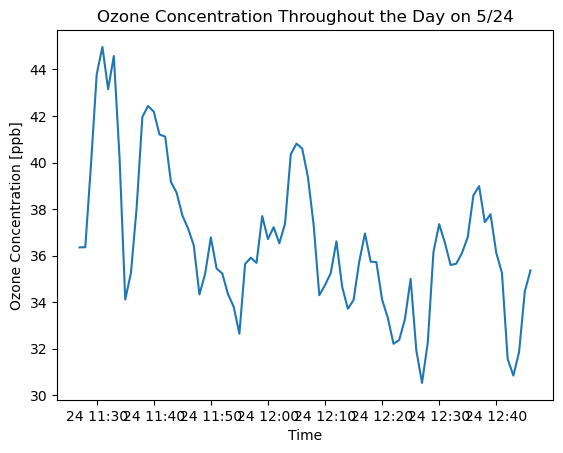

In [53]:
# This is the header information given from the attached dataset. 
o3_header = ["Station ID", "Time", "Output 1", "Ozone Average", "Output 2", "PGA Gain", "Output 3", "Instrument Gain", "Output 4", "Lamp Current", "Output 5", "Gas Pressure", "Output 6", "Ambeint Pressure", "Output 7", "Chassis Temperature", "Output 8", "Lamp Temperature", "Output 9", "Instrument Status", "Output 10", "Instrument State", "Output 11", "Instrument Units", "Output 12", "Filter Type"]
o3_data = pd.read_csv("O3_data.txt", header=None)
o3_data.set_axis(o3_header, axis=1, inplace=True)
# Dropping the header information columns because we don't need them. 
o3_data.drop(['Output 1', 'Output 2', 'Output 3', 'Output 4', 'Output 5', 'Output 6', 'Output 7', 'Output 8', 'Output 9', 'Output 10', 'Output 11', 'Output 12'], axis=1, inplace=True)
# Dropping the first few datasets - The Ozone sensor was getting warmed up... 
o3_data.drop(labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], axis=0, inplace=True)

## Creating the time variable as a datetime object, easier to handle and plot with. 
time_array_o3 = ["None"] * len(o3_data["Time"])
original_o3 = np.asarray(o3_data["Time"])
for i in range(len(o3_data["Time"])):
    time_array_o3[i] = original_o3[i].replace("/", "-")
new_time_array_o3 = np.asarray(time_array_o3, dtype='datetime64[s]')
plot = plt.plot(new_time_array_o3[51:], o3_data["Ozone Average"][51:])
plt.xlabel("Time")
plt.ylabel("Ozone Concentration [ppb]")
plt.title("Ozone Concentration Throughout the Day on 5/24")

Text(0.5, 1.0, 'NO Concentration Throughout the Day on 5/24')

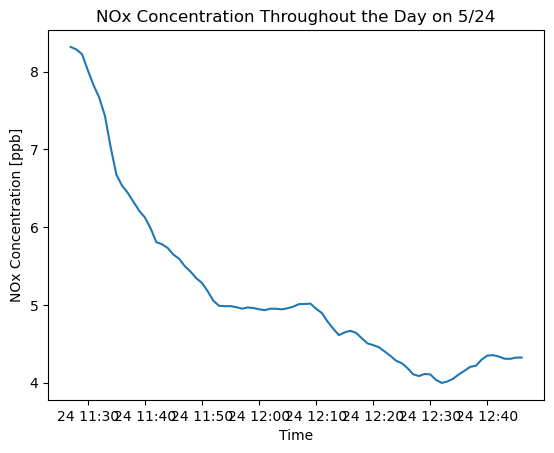

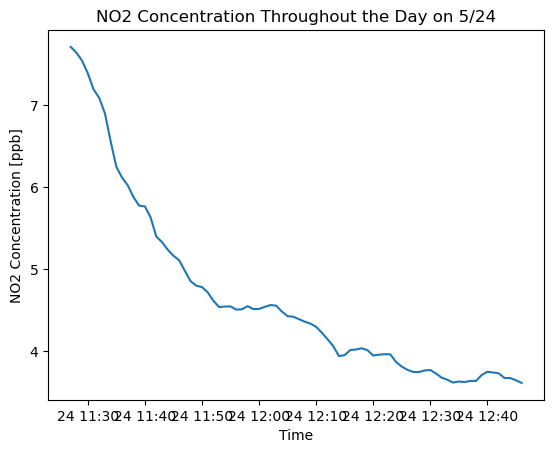

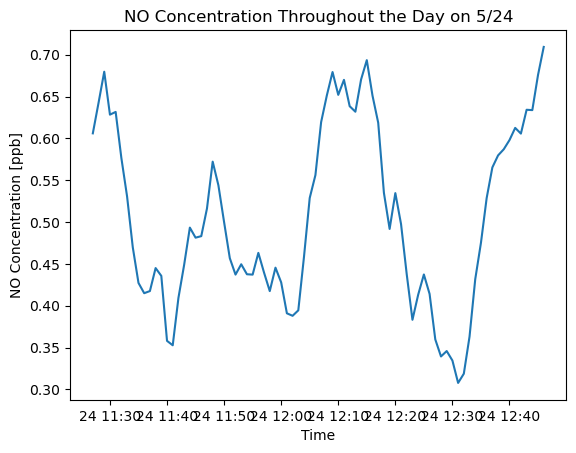

In [54]:
# This is the header information given from the attached dataset. 
NOx_header = ["Mysterious Value", "Time", "Output 1", "NO Concentration Average", "Output 2", "NOx Concentration Average", "Output 3", "NO2 Concentration Average", "Output 4", "NO Concentration", "Output 5", "NOx Concentration", "Output 6", "NO2 Concentration", "Output 7", "Gas Flow", "Output 8", "Chassis Temperature", "Output 9", "Instrument Status", "Output 10", "Instrument State", "Output 11", "Instrument Units", "Output 12", "Filter Type"]
NOx_data = pd.read_csv("NOx_data.txt", header=None)
NOx_data.set_axis(NOx_header, axis=1, inplace=True)

# Dropping the header information columns because we don't need them. 
NOx_data.drop(['Output 1', 'Output 2', 'Output 3', 'Output 4', 'Output 5', 'Output 6', 'Output 7', 'Output 8', 'Output 9', 'Output 10', 'Output 11', 'Output 12'], axis=1, inplace=True)
# Dropping the first few datasets - The Ozone sensor was getting warmed up... 
NOx_data.drop(labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,31,32,33,34], axis=0, inplace=True)
## Creating the time variable as a datetime object, easier to handle and plot with. 
time_array_NOx = ["None"] * len(NOx_data["Time"])
original_NOx = np.asarray(NOx_data["Time"])
for i in range(len(NOx_data["Time"])):
    time_array_NOx[i] = original_NOx[i].replace("/", "-")
new_time_array_NOx = np.asarray(time_array_NOx, dtype='datetime64[s]')

# Creating the Plots
plot = plt.plot(new_time_array_NOx[35:], NOx_data["NOx Concentration Average"][35:])
plt.xlabel("Time")
plt.ylabel("NOx Concentration [ppb]")
plt.title("NOx Concentration Throughout the Day on 5/24")

plt.figure()
plt.plot(new_time_array_NOx[35:], NOx_data["NO2 Concentration Average"][35:])
plt.xlabel("Time")
plt.ylabel("NO2 Concentration [ppb]")
plt.title("NO2 Concentration Throughout the Day on 5/24")

plt.figure()
plt.plot(new_time_array_NOx[35:], NOx_data["NO Concentration Average"][35:])
plt.xlabel("Time")
plt.ylabel("NO Concentration [ppb]")
plt.title("NO Concentration Throughout the Day on 5/24")

Text(0.5, 1.0, 'CO2 Concentration Throughout the Day on 5/24')

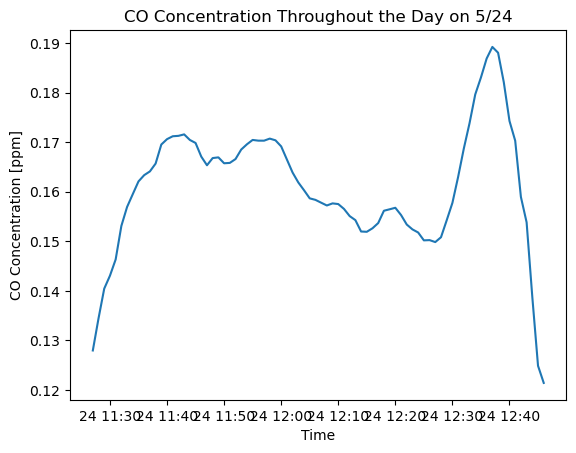

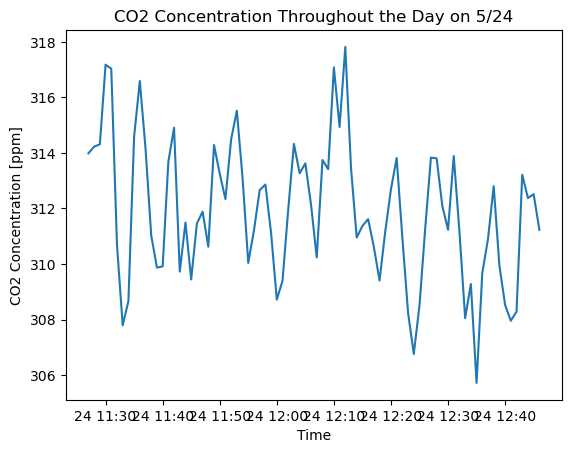

In [55]:
# This is the header information given from the attached dataset. 
CO_header = ["Mysterious Item", "Time", "Output 1", "CO Concentration", "Output 2", "CO2 Concentration", "Output 3", "CO Concentration Average", "Output 4", "CO2 Concentration Average", "Output 5", "Gas Flow", "Output 6", "Ambient Pressure", "Output 7", "Chassis Temperature", "Output 8", "Cooler Temperature", "Output 9", "Instrument Status", "Output 10", "Instrument State", "Output 11", "Primary Raw Concentration", "Output 12", "Noise"]
CO_data = pd.read_csv("CO_data.txt", header=None)
CO_data.set_axis(CO_header, axis=1, inplace=True)

# Dropping the header information columns because we don't need them. 
CO_data.drop(['Output 1', 'Output 2', 'Output 3', 'Output 4', 'Output 5', 'Output 6', 'Output 7', 'Output 8', 'Output 9', 'Output 10', 'Output 11', 'Output 12'], axis=1, inplace=True)
# Dropping the first few datasets - The Ozone sensor was getting warmed up... 
CO_data.drop(labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18, 19, 20, 21, 22, 23,24, 25, 26, 27, 28, 29, 30, 31, 32, 33,34, 35,36, 37, 38,39, 40, 41, 42, 43, 44, 45, 46], axis=0, inplace=True)

## Creating the time variable as a datetime object, easier to handle and plot with. 
time_array_CO = ["None"] * len(CO_data["Time"])
original_CO = np.asarray(CO_data["Time"])
for i in range(len(CO_data["Time"])):
    time_array_CO[i] = original_CO[i].replace("/", "-")
new_time_array_CO = np.asarray(time_array_CO, dtype='datetime64[s]')

# Creating the Plots
plot = plt.plot(new_time_array_CO[23:], CO_data["CO Concentration Average"][23:])
plt.xlabel("Time")
plt.ylabel("CO Concentration [ppm]")
plt.title("CO Concentration Throughout the Day on 5/24")

plt.figure()
plt.plot(new_time_array_CO[23:], CO_data["CO2 Concentration Average"][23:])
plt.xlabel("Time")
plt.ylabel("CO2 Concentration [ppm]")
plt.title("CO2 Concentration Throughout the Day on 5/24")

Text(0, 0.5, 'CO Gas Concentration [ppm]')

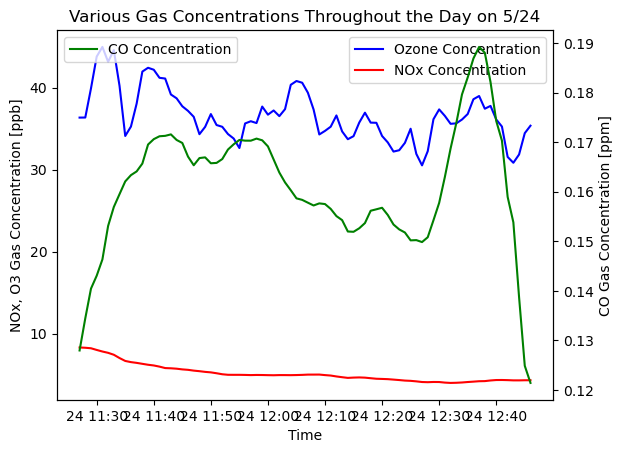

In [56]:
# Let's plot O3, CO, and NOx together.

fig, ax = plt.subplots()
plt.plot(new_time_array_o3[51:], o3_data["Ozone Average"][51:], color="Blue", label="Ozone Concentration")
plt.plot(new_time_array_NOx[35:], NOx_data["NOx Concentration Average"][35:], color="Red", label="NOx Concentration")
plt.ylabel("NOx, O3 Gas Concentration [ppb]")
plt.xlabel("Time")
plt.legend()

ax2 = ax.twinx()
ax2.plot(new_time_array_CO[23:], CO_data["CO Concentration Average"][23:], color="Green", label="CO Concentration")
plt.legend()
plt.title("Various Gas Concentrations Throughout the Day on 5/24")
plt.ylabel("CO Gas Concentration [ppm]")

Text(0.5, 1.0, 'NOx Concentration Throughout the Day on 5/24')

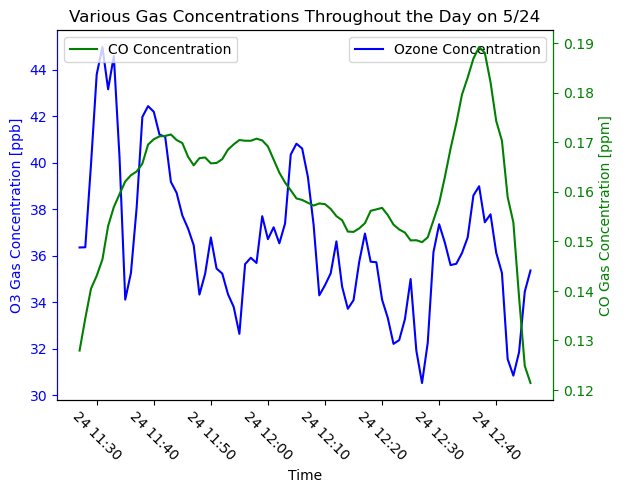

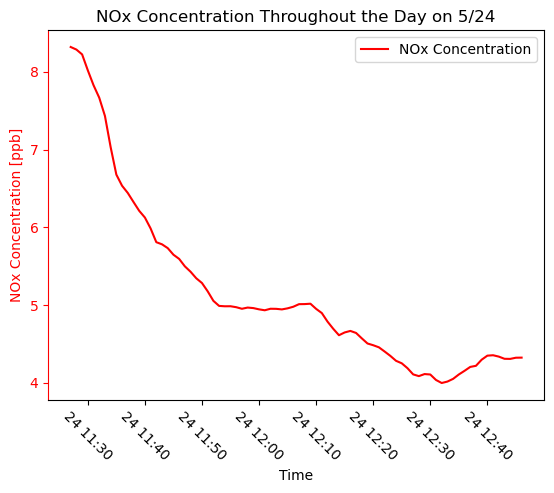

In [57]:
## Coloring the y-axis with Concentration Color

fig, ax = plt.subplots()
plt.plot(new_time_array_o3[51:], o3_data["Ozone Average"][51:], color="Blue", label="Ozone Concentration")
plt.ylabel("O3 Gas Concentration [ppb]", color="blue")
plt.xlabel("Time")
plt.xticks(rotation=315)
ax.tick_params(axis="y", colors="blue")
plt.legend()

ax2 = ax.twinx()
ax2.plot(new_time_array_CO[23:], CO_data["CO Concentration Average"][23:], color="Green", label="CO Concentration")
plt.legend()
ax2.spines["left"].set_color("blue")
ax2.spines["right"].set_color("green")
ax2.tick_params(axis='y', colors='green')
plt.title("Various Gas Concentrations Throughout the Day on 5/24")
plt.ylabel("CO Gas Concentration [ppm]", color="green")

fig, ax = plt.subplots()
plt.plot(new_time_array_NOx[35:], NOx_data["NOx Concentration Average"][35:], color="Red", label="NOx Concentration")
plt.ylabel("NOx Concentration [ppb]", color='red')
plt.xlabel("Time")
plt.xticks(rotation=315)
plt.legend()
ax.spines['left'].set_color("red")
ax.tick_params(axis="y", colors="red")
plt.title("NOx Concentration Throughout the Day on 5/24")

In [58]:
# Sanity Check
array = np.asarray(CO_data["CO2 Concentration"])
array[-2]

313.19043

In [59]:
"""
# Configure the nexrad interface using our time and location
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans_in_range(START, STOP, RADAR_ID)
print("There are {} scans available between {} and {}\n".format(len(scans), START, STOP))

# Download the files
results = conn.download(scans, templocation)
"""

'\n# Configure the nexrad interface using our time and location\nconn = nexradaws.NexradAwsInterface()\nscans = conn.get_avail_scans_in_range(START, STOP, RADAR_ID)\nprint("There are {} scans available between {} and {}\n".format(len(scans), START, STOP))\n\n# Download the files\nresults = conn.download(scans, templocation)\n'

In [60]:
## NEIU AQT 
df_aq = sage_data_client.query(start = DATE + 'T' + TIME_START + 'Z',
                               end = DATE + 'T' + TIME_STOP + 'Z', 
                               filter={
                                        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                                       }
)
# extract the particle measurements from the DataFrame
pm25 = df_aq[df_aq['name']=='aqt.particle.pm2.5']
pm10 = df_aq[df_aq['name']=='aqt.particle.pm1']
pm100 = df_aq[df_aq['name']=='aqt.particle.pm10']

# extract the gas measurements from the DataFrame
no = df_aq[df_aq['name']=='aqt.gas.no']
o3 = df_aq[df_aq['name']=='aqt.gas.ozone']
no2 = df_aq[df_aq['name']=='aqt.gas.no2']
co = df_aq[df_aq['name']=='aqt.gas.co']

# extract the environment data from the DataFrame
aqtemp = df_aq[df_aq['name']=='aqt.env.temp']
aqhum = df_aq[df_aq['name']=='aqt.env.humidity']

# Convert values to numpy arrays
aqvals = pm25.set_index('timestamp')
aqvals['pm2.5'] = aqvals.value.to_numpy().astype(float)
aqvals['pm1.0'] = pm10.value.to_numpy().astype(float)
aqvals['pm10.0'] = pm100.value.to_numpy().astype(float)
aqvals['no'] = no.value.to_numpy().astype(float)
aqvals['o3'] = o3.value.to_numpy().astype(float)
aqvals['no2'] = no2.value.to_numpy().astype(float)
aqvals['co'] = co.value.to_numpy().astype(float)
aqvals['temp'] =  aqtemp.value.to_numpy().astype(float)
aqvals['hum'] =  aqhum.value.to_numpy().astype(float)

# Use MetPY to calculate dewpoint from temperature and relative humidity
dp = dewpoint_from_relative_humidity( aqvals.temp.to_numpy() * units.degC, 
                                     aqvals.hum.to_numpy() * units.percent)

aqvals['dewpoint'] = dp

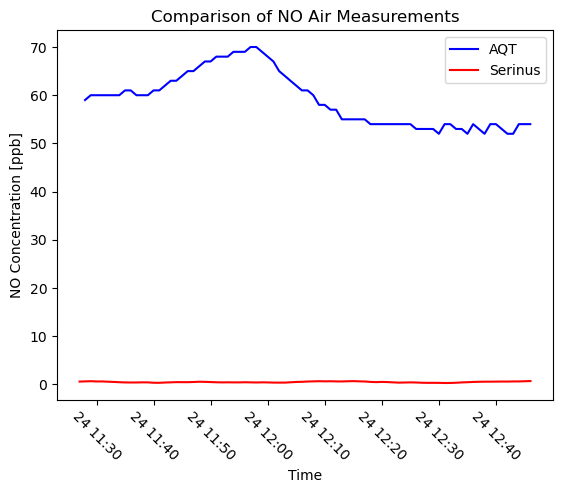

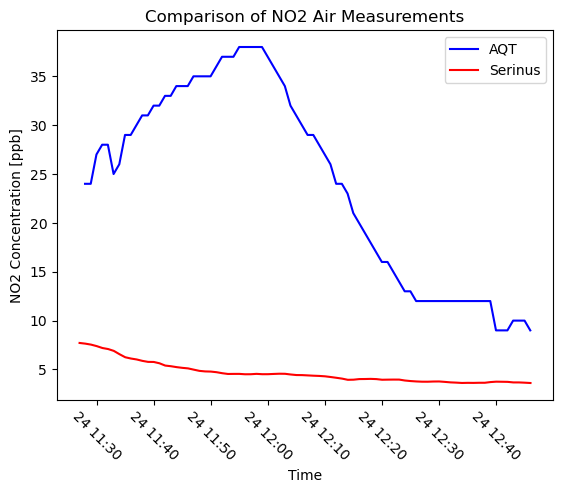

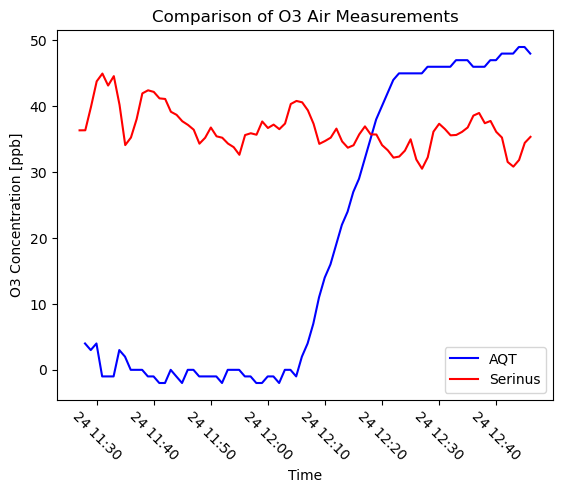

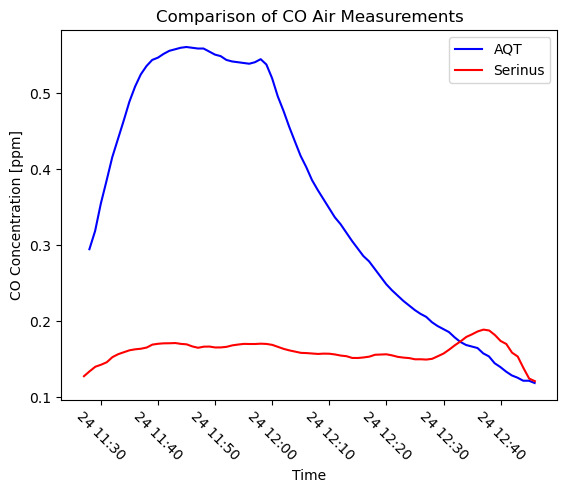

In [61]:
## Making a comparison between AQT and Serinus for NO
plt.plot(no["timestamp"], no["value"]*1000, label="AQT", color="Blue")
plt.plot(new_time_array_NOx[35:], NOx_data["NO Concentration Average"][35:], label="Serinus", color="Red")
plt.legend()
plt.xticks(rotation=315)
plt.title("Comparison of NO Air Measurements")
plt.ylabel("NO Concentration [ppb]")
plt.xlabel("Time")
plt.savefig("NO Comparison")

## Making a comparison between AQT and Serinus for NO2
plt.figure()
plt.plot(no2["timestamp"], no2["value"]*1000, label="AQT", color="Blue")
plt.plot(new_time_array_NOx[35:], NOx_data["NO2 Concentration Average"][35:], label="Serinus", color="Red")
plt.legend()
plt.xticks(rotation=315)
plt.title("Comparison of NO2 Air Measurements")
plt.ylabel("NO2 Concentration [ppb]")
plt.xlabel("Time")
plt.savefig("NO2 Comparison")

## Making a comparison between AQT and Serinus for O3
plt.figure()
plt.plot(o3["timestamp"], o3["value"]*1000, label="AQT", color="Blue")
plt.plot(new_time_array_o3[51:], o3_data["Ozone Average"][51:], label="Serinus", color="Red")
plt.legend()
plt.xticks(rotation=315)
plt.title("Comparison of O3 Air Measurements")
plt.ylabel("O3 Concentration [ppb]")
plt.xlabel("Time")
plt.savefig("o3 Comparison")

## Making a comparison between AQT and Serinus for CO
plt.figure()
plt.plot(co["timestamp"], co["value"], label="AQT", color="Blue")
plt.plot(new_time_array_CO[23:], CO_data["CO Concentration Average"][23:], label="Serinus", color="Red")
plt.legend()
plt.xticks(rotation=315)
plt.title("Comparison of CO Air Measurements")
plt.ylabel("CO Concentration [ppm]")
plt.xlabel("Time")
plt.savefig("CO Comparison")

In [30]:
## Creating a scatterplot for NO concentration levels across AQT and Serinus data values. 
cm = plt.cm.get_cmap('RdYlBu')
print(len(NOx_data["NO Concentration Average"))
# sc = plt.scatter(no["value"]*1000, NOx_data["NO Concentration Average"][35:-1], c=aqhum["value"], cmap=cm)
"""
cbar = plt.colorbar(sc)
cbar.set_label("Difference")
plt.xlabel("AQT Sensor Data")
plt.ylabel("Serinus Sensor Data")
plt.title("Scatterplot of AQT and Serinus Data Values for NO")
plt.savefig("NO Scatter")
"""

1440


'\ncbar = plt.colorbar(sc)\ncbar.set_label("Difference")\nplt.xlabel("AQT Sensor Data")\nplt.ylabel("Serinus Sensor Data")\nplt.title("Scatterplot of AQT and Serinus Data Values for NO")\nplt.savefig("NO Scatter")\n'

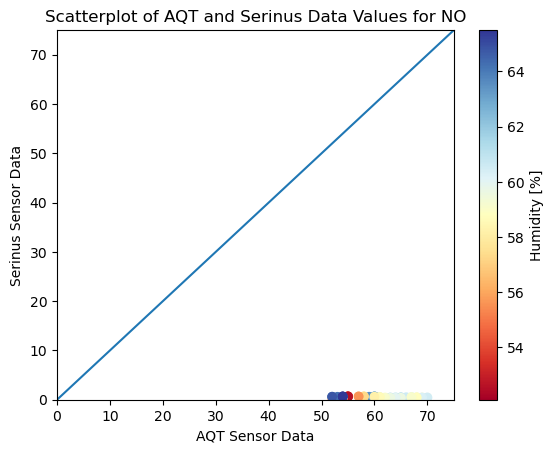

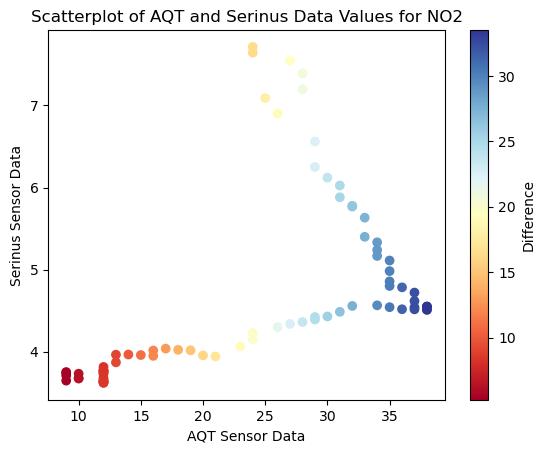

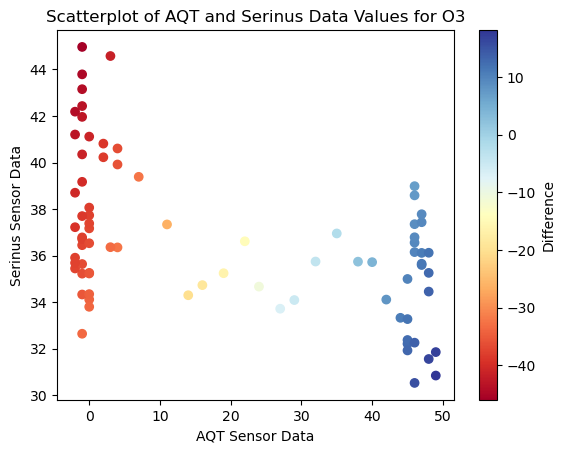

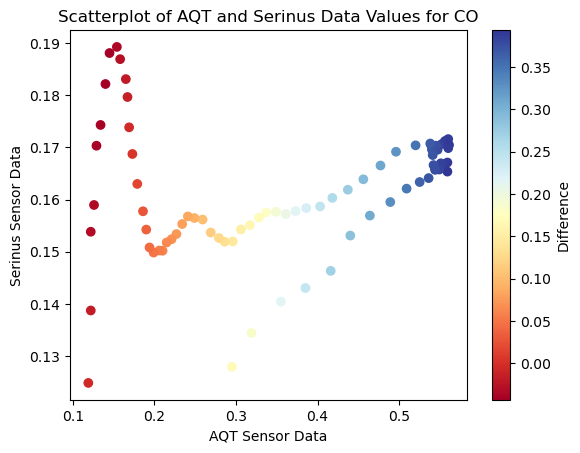

In [65]:
## Creating a scatterplot for NO concentration levels across AQT and Serinus data values. 
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(no["value"]*1000, NOx_data["NO Concentration Average"][35:-1], c=aqhum["value"], cmap=cm)
cbar = plt.colorbar(sc)
cbar.set_label("Humidity [%]")
plt.xlabel("AQT Sensor Data")
plt.ylabel("Serinus Sensor Data")
plt.xlim(0,75)
plt.ylim(0,75)
plt.plot([0,75],[0,75])
plt.title("Scatterplot of AQT and Serinus Data Values for NO")
plt.savefig("NO Scatter")

plt.figure()
diff_no2 = np.array(no2["value"]*1000) - np.array(NOx_data["NO2 Concentration Average"][35:-1])
sc = plt.scatter(no2["value"]*1000, NOx_data["NO2 Concentration Average"][35:-1], c=diff_no2, cmap=cm)
cbar = plt.colorbar(sc)
cbar.set_label("Difference")
plt.xlabel("AQT Sensor Data")
plt.ylabel("Serinus Sensor Data")
plt.title("Scatterplot of AQT and Serinus Data Values for NO2")
plt.savefig("NO2 Scatter")

plt.figure()
diff_o3 = np.array(o3["value"]*1000) - np.array(o3_data["Ozone Average"][51:-1])
sc = plt.scatter(o3["value"]*1000, o3_data["Ozone Average"][51:-1], c=diff_o3, cmap=cm)
cbar = plt.colorbar(sc)
cbar.set_label("Difference")
plt.xlabel("AQT Sensor Data")
plt.ylabel("Serinus Sensor Data")
plt.title("Scatterplot of AQT and Serinus Data Values for O3")
plt.savefig("o3 Scatter")

plt.figure()
diff_CO = np.array(co["value"]) - np.array(CO_data["CO Concentration Average"][23:-1])
sc = plt.scatter(co["value"], CO_data["CO Concentration Average"][23:-1], c=diff_CO, cmap=cm)
cbar = plt.colorbar(sc)
cbar.set_label("Difference")
plt.xlabel("AQT Sensor Data")
plt.ylabel("Serinus Sensor Data")
plt.title("Scatterplot of AQT and Serinus Data Values for CO") 
plt.savefig("CO Scatter")

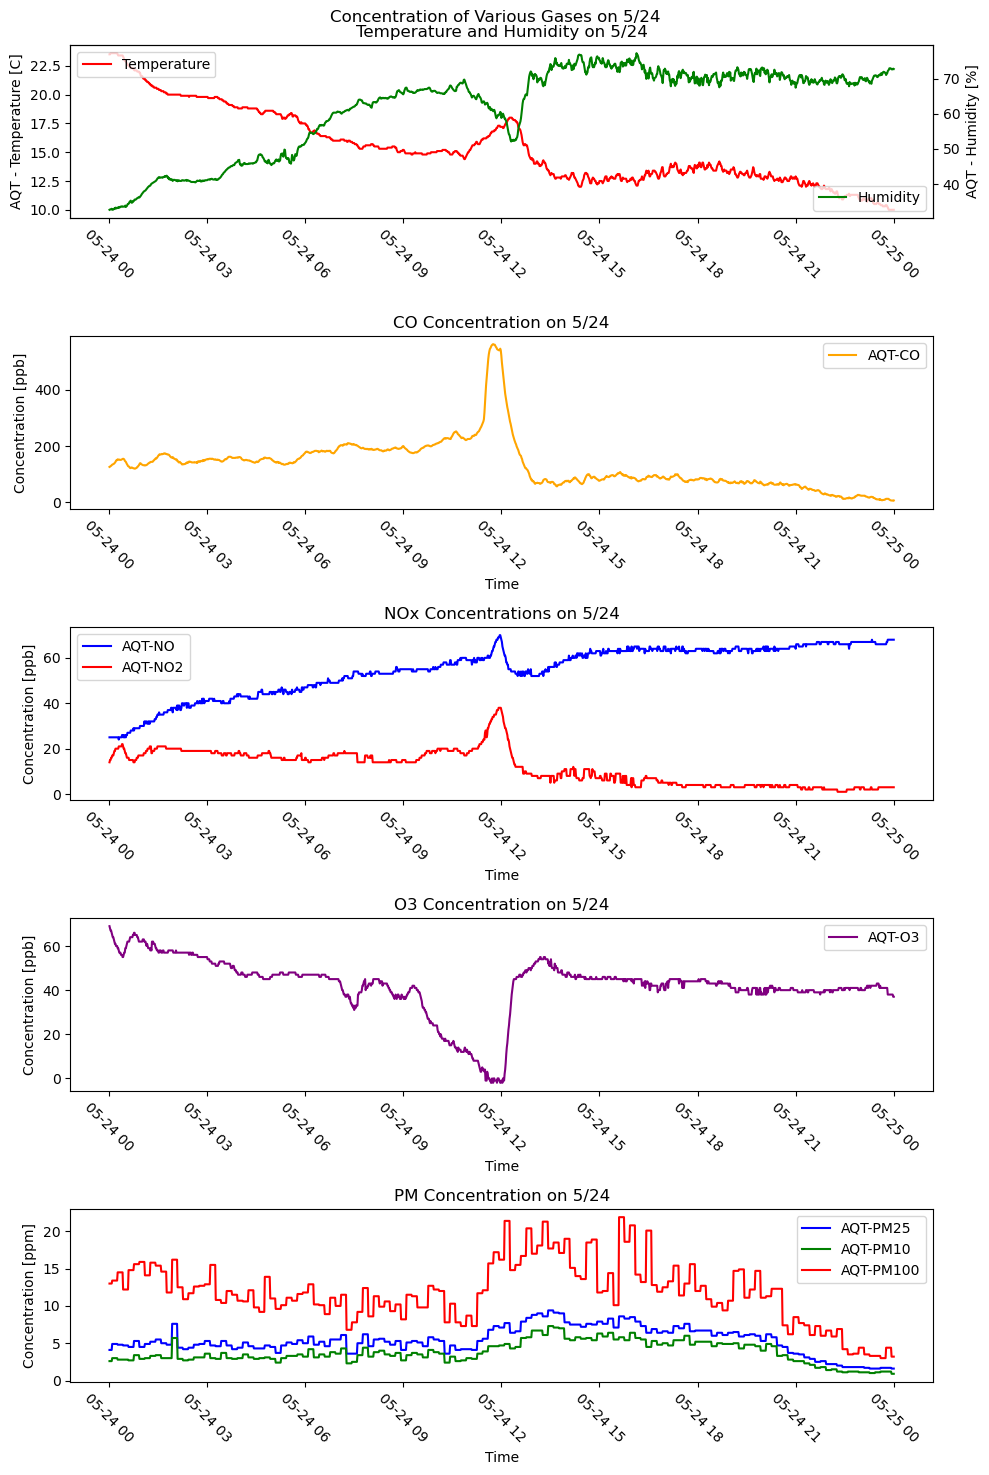

In [84]:
## Making above as a subplot

plt.figure(figsize=(10,15))
ax1 = plt.subplot(5,1,1)
plt.plot(aqtemp["timestamp"], aqtemp["value"], label="Temperature", color="Red")
plt.ylabel("AQT - Temperature [C]")
plt.xticks(rotation=315)
plt.legend(loc=2)
plt.title("Temperature and Humidity on 5/24")
ax2 = ax1.twinx()
ax2.plot(aqhum["timestamp"], aqhum["value"], label="Humidity", color="Green")
plt.ylabel("AQT - Humidity [%]")
plt.legend(loc=4)
plt.xlabel("Time")

plt.subplot(5,1,2)
plt.plot(co["timestamp"], co["value"]*1000, label="AQT-CO", color="Orange")
plt.ylabel("Concentration [ppb]")
plt.title("CO Concentration on 5/24")
plt.legend()
plt.xticks(rotation=315)
plt.xlabel("Time")

plt.subplot(5,1,3)
plt.plot(no["timestamp"], no["value"]*1000, label="AQT-NO", color="Blue")
plt.plot(no2["timestamp"], no2["value"]*1000, label="AQT-NO2", color="Red")
plt.ylabel("Concentration [ppb]")
plt.title("NOx Concentrations on 5/24")
plt.legend()
plt.xticks(rotation=315)
plt.xlabel("Time")

plt.subplot(5,1,4)
plt.plot(o3["timestamp"], o3["value"]*1000, label="AQT-O3", color="Purple")
plt.ylabel("Concentration [ppb]")
plt.title("O3 Concentration on 5/24")
plt.legend()
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.suptitle("Concentration of Various Gases on 5/24")

## Adding in plots for PM
plt.subplot(5,1,5)
plt.plot(pm25["timestamp"], pm25["value"], label="AQT-PM25", color="Blue")
plt.plot(pm10["timestamp"], pm10["value"], label="AQT-PM10", color="Green")
plt.plot(pm100["timestamp"], pm100["value"], label="AQT-PM100", color="Red")
plt.ylabel("Concentration [ppm]")
plt.title("PM Concentration on 5/24")
plt.legend()
plt.xticks(rotation=315)
plt.xlabel("Time")

plt.tight_layout()
plt.savefig("Comparison")

In [ ]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

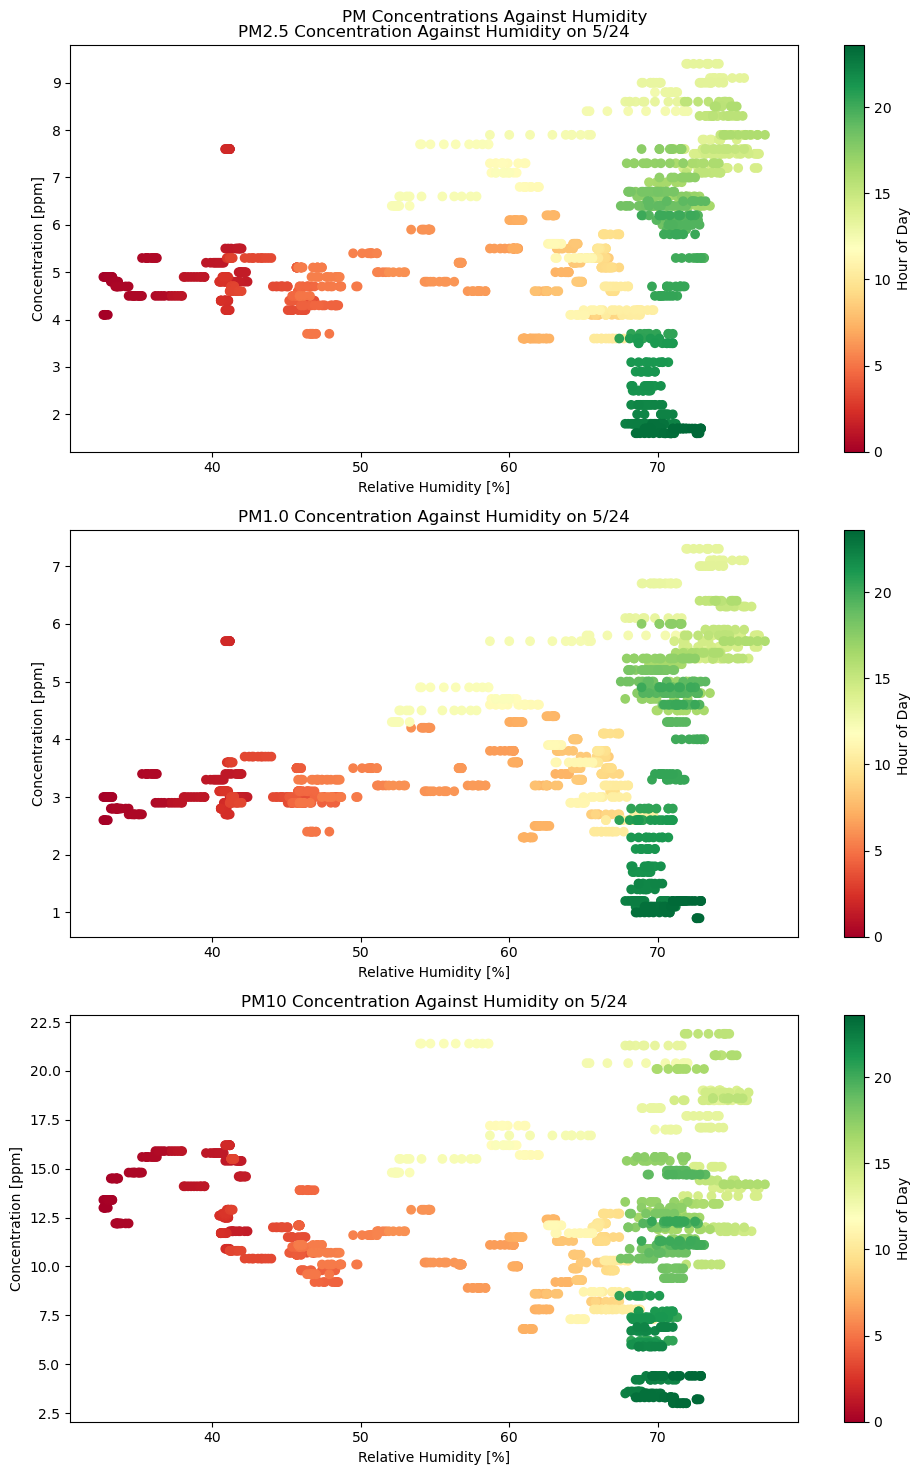

In [155]:
# Plotting PM against RH
cm = plt.cm.get_cmap('RdYlGn')

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
## For PM2.5 dataset, the timestamp has sequential keys between 15840 and 17279
time = ["None"] * len(pm25["timestamp"])
for i in range(15840, 17279):
    time[i-15840] = pm25["timestamp"][i].hour + (pm25["timestamp"][i].minute)/100
smap = plt.scatter(aqhum["value"][:-1], pm25["value"][:-1], c=time[:-1], cmap=cm)
cb = plt.colorbar(smap)
cb.set_label("Hour of Day")
plt.xlabel("Relative Humidity [%]")
plt.ylabel("Concentration [ppm]")
plt.title("PM2.5 Concentration Against Humidity on 5/24")

plt.subplot(3,1,2)
time = ["None"] * len(pm10["timestamp"])
# For PM1.0 dataset, the timestamp has sequential keys between 12960 and 14399
for i in range(12960, 14399):
    time[i-12960] = pm10["timestamp"][i].hour + (pm10["timestamp"][i].minute)/100
smap = plt.scatter(aqhum["value"][:-1], pm10["value"][:-1], c=time[:-1], cmap=cm)
cb = plt.colorbar(smap)
cb.set_label("Hour of Day")
plt.xlabel("Relative Humidity [%]")
plt.ylabel("Concentration [ppm]")
plt.title("PM1.0 Concentration Against Humidity on 5/24")

plt.subplot(3,1,3)
time = ["None"] * len(pm100["timestamp"])
# For PM10 dataset, the timestamp has sequential keys between 14400 and 15839
for i in range(14400, 15839):
    time[i-14400] = pm100["timestamp"][i].hour + (pm100["timestamp"][i].minute)/100
smap = plt.scatter(aqhum["value"][:-1], pm100["value"][:-1], c=time[:-1], cmap=cm)
cb = plt.colorbar(smap)
cb.set_label("Hour of Day")
plt.xlabel("Relative Humidity [%]")
plt.ylabel("Concentration [ppm]")
plt.title("PM10 Concentration Against Humidity on 5/24")

plt.suptitle("PM Concentrations Against Humidity")
plt.tight_layout()
plt.savefig("PM Concentrations Humidity")

In [154]:
for i, scan in enumerate(results.iter_success(), start=1):
    ## skip the files ending in "MDM"
    
    if scan.filename[-3:] != "MDM":
        if i > 1:
            # define what file you are working on
            print("working on " + scan.filename)
            # define the radar time
            rad_time = scan.filename[4:8] + '-' + scan.filename[8:10] + '-' + scan.filename[10:12] + \
                       ' ' + scan.filename[13:15] + ':' + scan.filename[15:17] + ':' + scan.filename[17:19]
            # Open the file with PyART
            radar = scan.open_pyart()
            # Call the CROCUS AQ Display Function
            chicago_aq_display(aqvals, 
                               rad_time,
                               templocation=templocation)
            # close the radar file
            del radar

NameError: name 'results' is not defined